# Component contribution analysis

From the hyperparameter tuning step, we have selected a set of parameters ($\lambda$,  $ \vartheta$, k) with largest **LLPD$_o$**.  

Here we aim to evaluate the contribution of each of the components in the generative model (MEM). The generative model for the ocean microbiome data for the microbial abundance data consists of **geochemical component**, **spatio-temporal components indicating geographical location, ocean depth and time** and **species-species interaction component**. To understand their  contribution in the MEM, we drop each of the specific component in the generative model, estimate the variational posterior and then evaluate the model performance in terms of the **out of sample log-likelihood predictive density (LLPD$_o$)**.


Steps of the analysis
 + Define component excluded generative model
 + Python script for the variational posterior estimation: **component_contribution_fit.py**
 + Script to call component excluded generative model  
 + Evaluate the model in terms of the **LLPD$_o$**

 
#### Component excluded generative model
We have defined the component excluded stan model (see stan_model folder) in the following files:
 + **NB_microbe_ppc.stan** : Full model [Model = 0]
 + **NB_microbe_ppc-1.stan** : Province component dropped  [Model = 1]
 + **NB_microbe_ppc-2.stan** : Biome component dropped  [Model = 2]
 + **NB_microbe_ppc-3.stan** : Quarter/Time component dropped  [Model = 3]
 + **NB_microbe_ppc-G.stan** : Geochemical component dropped  [Model = 4]
 + **NB_microbe_ppc_nointer.stan** : Species-species interaction component dropped  [Model = 5]

#### Script to evaluate the model
For the chosen set of hyperparameters, we compute the variational posterior of each the **component excluded generative model** for **twenty** different initialization. We have saved the command calling **component_contribution_fit.py** for each of the  **component excluded generative model** in the file **mem_component_contribution** (see the python cript below to generate the file).

A line in the file **mem_component_contribution** calls the python script **component_contribution_fit.py** for a given choice of the parameters. 

*module purge ; module load slurm gcc python3 ; OMP_NUM_THREADS=1 python3 component_contribution_fit.py 100.0 0.219 0.06503 0.1 200 1 0 1.0 > logfile/1.log 2>&1*

Input parameters for a setting includes **latent rank (k),  $\lambda$,  $\vartheta$, test sample proportion, variational posterior sample size,  sub-settings unique ID (1-20), model type  and setting seed**. 


#### Parameter estimation 
We run the script on server using the command:
*sbatch -N [#node] -p [#partition] disBatch.py -t [#task on each node] [script_file]*
Example: *sbatch -N 10 -p ccm disBatch.py -t 25 mem_component_contribution*




#### Model output analysis
Evaluate each of the **component excluded generative model** based on the $LLPD_o$. Let us consider our model output is saved in the folder **CContribution**. To compare the model, we load the output file and compute the $LLPD_o$ for each model. 

In [1]:
## Load all the required python module for the analysis 
import glob 
import pickle as pkl
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hiplot as hip
import os 
import copy 
%matplotlib inline

# 1. Read config_mode.txt
config_file = "config_mode.txt"
if os.path.exists(config_file):
    with open(config_file, "r") as f:
        lines = f.read().splitlines()
        data = lines[0].strip() if len(lines) > 0 else "original"
        setting = int(lines[1]) if len(lines) > 1 else 1


# 2. Set plots folder based on config
if data == "original" and setting == 1: 
    figfol = "./plots1/"
elif data == "original" and setting == 2:
    figfol = "./plots2/"
elif data == "new" and setting == 2: 
    figfol = "./plots3/"
elif data == "new" and setting == 1: 
    figfol = "./plots4/"

if not os.path.exists(figfol):
    os.makedirs(figfol)
    print(f"✅ Created folder: {figfol}")
else:
    print(f"📂 Folder already exists: {figfol}")

if data == "original" and setting == 1:
    fname_o = glob.glob('../results/results_old_c/component/models/extracted/*model_nb_cvtest.pkl')
elif data == "original" and setting ==2: 
    fname_o = glob.glob('../results/results_old_nc/component/models/*model_nb_cvtest.pkl') 
elif data =="new" and setting ==2: 
    fname_o = glob.glob('../results/results_new_var_nc/component/models/*model_nb_cvtest.pkl') 
elif data =="new" and setting ==1: 
    fname_o = glob.glob('../results/results_new_var_c/component/models/*model_nb_cvtest.pkl') 
print("Loaded files (first 10):", fname_o[:10])
print("Loaded files (first 10):", fname_o[:10])


📂 Folder already exists: ./plots4/
Loaded files (first 10): ['../results/results_new_var_c/component/models/30_9_13_model_nb_cvtest.pkl', '../results/results_new_var_c/component/models/30_11_17_model_nb_cvtest.pkl', '../results/results_new_var_c/component/models/30_8_13_model_nb_cvtest.pkl', '../results/results_new_var_c/component/models/30_9_3_model_nb_cvtest.pkl', '../results/results_new_var_c/component/models/30_8_3_model_nb_cvtest.pkl', '../results/results_new_var_c/component/models/30_12_7_model_nb_cvtest.pkl', '../results/results_new_var_c/component/models/30_12_16_model_nb_cvtest.pkl', '../results/results_new_var_c/component/models/30_10_19_model_nb_cvtest.pkl', '../results/results_new_var_c/component/models/30_12_12_model_nb_cvtest.pkl', '../results/results_new_var_c/component/models/30_10_1_model_nb_cvtest.pkl']
Loaded files (first 10): ['../results/results_new_var_c/component/models/30_9_13_model_nb_cvtest.pkl', '../results/results_new_var_c/component/models/30_11_17_model_nb

In [9]:
# Already defined earlier:
# fname_o = glob.glob(...) → a list of model file paths

model_files = fname_o  # Already globbed earlier
print(f"✅ Found {len(model_files)} model files.")

# Extract model data
model_data = []

for model_file in model_files:
    with open(model_file, "rb") as file:
        try:
            data = pkl.load(file)
            if len(data) < 18:
                print(f"⚠️ Skipping {model_file} - Unexpected structure")
                continue

            holdout_mask = data[0]
            l = data[4]
            sp_mean = data[6]
            sp_var = data[7]
            uid = 30
            model_type = data[10]
            cv_test = data[13]

            se_index = holdout_mask == 1
            llpd = np.mean(cv_test[se_index]) if isinstance(cv_test, np.ndarray) and np.any(se_index) else np.nan

            model_data.append([model_file, model_type, l, sp_mean, sp_var, llpd, uid])

        except Exception as e:
            print(f"❌ Error processing {model_file}: {e}")

# Build and display the DataFrame
columns = ['Filename', 'Model', 'Lambda', 'Mean SP', 'Variance SP', 'LLPD', 'UID']
df_models = pd.DataFrame(model_data, columns=columns).sort_values(by="LLPD", ascending=False)

from IPython.display import display
styled_df = df_models.head(10).style.background_gradient(cmap="viridis").set_properties(**{'text-align': 'center'})
display(styled_df)


✅ Found 128 model files.


,Filename,Model,Lambda,Mean SP,Variance SP,LLPD,UID
107,../results/results_new_var_c/component/models/30_8_1_model_nb_cvtest.pkl,8,100,0.021644,0.050383,23.244011,30
34,../results/results_new_var_c/component/models/30_14_15_model_nb_cvtest.pkl,14,100,0.021644,0.050383,22.833488,30
87,../results/results_new_var_c/component/models/30_14_14_model_nb_cvtest.pkl,14,100,0.021644,0.050383,22.741068,30
92,../results/results_new_var_c/component/models/30_9_4_model_nb_cvtest.pkl,9,100,0.021644,0.050383,22.708798,30
5,../results/results_new_var_c/component/models/30_12_7_model_nb_cvtest.pkl,12,100,0.021644,0.050383,22.575330,30
121,../results/results_new_var_c/component/models/30_11_14_model_nb_cvtest.pkl,11,100,0.021644,0.050383,22.492926,30
25,../results/results_new_var_c/component/models/30_11_4_model_nb_cvtest.pkl,11,100,0.021644,0.050383,22.492410,30
68,../results/results_new_var_c/component/models/30_12_17_model_nb_cvtest.pkl,12,100,0.021644,0.050383,22.466388,30
12,../results/results_new_var_c/component/models/30_12_9_model_nb_cvtest.pkl,12,100,0.021644,0.050383,22.398854,30
66,../results/results_new_var_c/component/models/30_10_18_model_nb_cvtest.pkl,10,100,0.021644,0.050383,22.395911,30


In [3]:
import pickle 
for file in fname_o:
    print(f"Inspecting file: {os.path.relpath(file)}")
    try:
        with open(file, "rb") as f:
            data = pickle.load(f)
        
        # Check if the data is iterable (e.g., list, tuple, dict)
        if isinstance(data, (list, tuple)):
            print(f"File contains a {type(data).__name__} with {len(data)} elements.")
            for i, element in enumerate(data):
                print(f"  Element {i}: Type={type(element)}")
        elif isinstance(data, dict):
            print(f"File contains a dictionary with {len(data)} keys.")
            for key, value in data.items():
                print(f"  Key='{key}': Type={type(value)}")
        else:
            print(f"File contains a single object of type {type(data).__name__}.")
    except Exception as e:
        print(f"Error while reading {file}: {e}")
    print("-" * 50)

Inspecting file: ../results/results_new_var_c/component/models/30_9_13_model_nb_cvtest.pkl
File contains a list with 18 elements.
  Element 0: Type=<class 'numpy.ndarray'>
  Element 1: Type=<class 'int'>
  Element 2: Type=<class 'int'>
  Element 3: Type=<class 'int'>
  Element 4: Type=<class 'int'>
  Element 5: Type=<class 'int'>
  Element 6: Type=<class 'float'>
  Element 7: Type=<class 'float'>
  Element 8: Type=<class 'float'>
  Element 9: Type=<class 'int'>
  Element 10: Type=<class 'int'>
  Element 11: Type=<class 'numpy.ndarray'>
  Element 12: Type=<class 'numpy.ndarray'>
  Element 13: Type=<class 'numpy.ndarray'>
  Element 14: Type=<class 'numpy.ndarray'>
  Element 15: Type=<class 'numpy.ndarray'>
  Element 16: Type=<class 'int'>
  Element 17: Type=<class 'int'>
--------------------------------------------------
Inspecting file: ../results/results_new_var_c/component/models/30_11_17_model_nb_cvtest.pkl
File contains a list with 18 elements.
  Element 0: Type=<class 'numpy.ndarra

In [4]:
import pickle
import os

# Only inspect the first file
file = fname_o[0]
print(f"🔍 Inspecting file: {os.path.relpath(file)}")
print("=" * 60)

try:
    with open(file, "rb") as f:
        data = pickle.load(f)

    if isinstance(data, (list, tuple)):
        print(f"✅ File contains a {type(data).__name__} with {len(data)} elements.\n")

        for i, element in enumerate(data):
            print(f"📦 Element {i}:")
            print(f"   Type   : {type(element)}")
            if isinstance(element, (int, float, str, bool)):
                print(f"   Value  : {element}")
            elif isinstance(element, (list, tuple, set)):
                print(f"   Length : {len(element)}")
                print(f"   Preview: {list(element)[:5]}")
            elif hasattr(element, "shape"):
                print(f"   Shape  : {element.shape}")
                print(f"   Dtype  : {element.dtype}")
                print(f"   Preview: {element.flatten()[:5]}")
            else:
                print(f"   Value  : {repr(element)}")
            print("-" * 50)

    elif isinstance(data, dict):
        print(f"✅ File contains a dictionary with {len(data)} keys.\n")
        for key, value in data.items():
            print(f"🔑 Key: {key}")
            print(f"   Type   : {type(value)}")
            if isinstance(value, (int, float, str, bool)):
                print(f"   Value  : {value}")
            elif hasattr(value, "shape"):
                print(f"   Shape  : {value.shape}")
                print(f"   Preview: {value.flatten()[:5]}")
            elif isinstance(value, (list, tuple, set)):
                print(f"   Length : {len(value)}")
                print(f"   Preview: {list(value)[:5]}")
            else:
                print(f"   Value  : {repr(value)}")
            print("-" * 50)
    else:
        print(f"⚠️ File contains a single object of type {type(data).__name__}")
        print(f"   Value: {repr(data)}")

except Exception as e:
    print(f"❌ Error while reading {file}: {e}")

print("=" * 60)


🔍 Inspecting file: ../results/results_new_var_c/component/models/30_9_13_model_nb_cvtest.pkl
✅ File contains a list with 18 elements.

📦 Element 0:
   Type   : <class 'numpy.ndarray'>
   Shape  : (180, 1076)
   Dtype  : float64
   Preview: [0. 0. 1. 0. 1.]
--------------------------------------------------
📦 Element 1:
   Type   : <class 'int'>
   Value  : 0
--------------------------------------------------
📦 Element 2:
   Type   : <class 'int'>
   Value  : 0
--------------------------------------------------
📦 Element 3:
   Type   : <class 'int'>
   Value  : 0
--------------------------------------------------
📦 Element 4:
   Type   : <class 'int'>
   Value  : 100
--------------------------------------------------
📦 Element 5:
   Type   : <class 'int'>
   Value  : 13
--------------------------------------------------
📦 Element 6:
   Type   : <class 'float'>
   Value  : 0.021644
--------------------------------------------------
📦 Element 7:
   Type   : <class 'float'>
   Value  : 0.0

In [2]:
# Extract model output and compute LLPD
out = {}

for i in range(len(fname_o)):
    if (i % 20) == 0:
        print(i)

    # Load the model file
    with open(fname_o[i], "rb") as file:
        [holdout_mask, Yte_sample, llpd, n_test, l, m_seed, sp_mean,
         sp_var, h_prop, uid, nsample_o, Yte_fit,
         cv_test, Y, muest, Yte_cv, Yte_lpmf, kl_comp] = pkl.load(file)

    se_index = holdout_mask == 1.

    # Compute LLPD
    temp_ll = cv_test[se_index]
    temp_ll = np.mean(temp_ll)

    # Extract mtype correctly
    filename = os.path.basename(fname_o[i])  # Extract only the filename
    filename_parts = filename.split('_')  # Split by '_'
    #print(filename_parts[1])

    if len(filename_parts) >= 3:
        mtype = int(filename_parts[1])  # Extract the second part (e.g., "0" from "30_0_10_model_nb_cvtest.pkl")
    else:
        raise ValueError(f"Unexpected filename format: {filename}")
    if len(filename_parts) >= 4:
        mtype = int(filename_parts[1])  # because filename is: mseed_mtype_uid_model_nb_cvtest.pkl
    else:
        raise ValueError(f"Unexpected filename format: {filename}")

    # Compute error
    error = np.mean(np.power(Y - muest, 2)[se_index])

    # Store results
    out[i] = [i, l, sp_mean, sp_var, temp_ll, uid, mtype] #[i, l, sp_mean, sp_var, temp_ll, uid, mtype]

print("Processing complete!")


0
20
40
60
80
100
120
Processing complete!


In [6]:
values = cv_test[se_index]
print("cv_test (holdout):", values)
print("np.any(np.isinf(values)):", np.any(np.isinf(values)))
print("np.mean(values):", np.mean(values))


cv_test (holdout): [-2.77031143 -2.28796731 -2.71318536 ... -2.65671152 -2.81708494
 -2.5830673 ]
np.any(np.isinf(values)): True
np.mean(values): -inf


In [7]:
print("Sample entry in 'out':", next(iter(out.values())))

Sample entry in 'out': [0, 100, 0.021644, 0.050383, -3.5317111649846975, 30, 9]


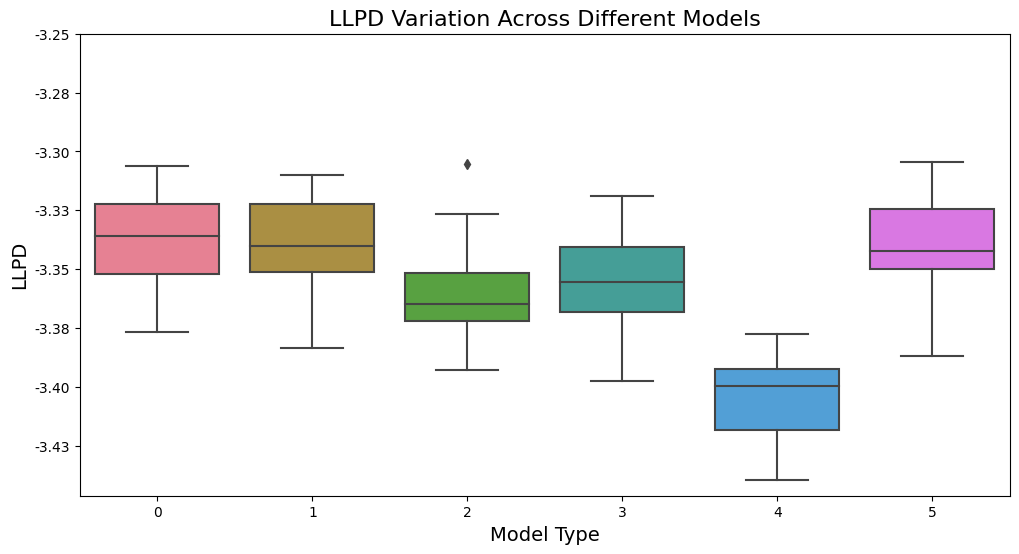

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Convert dictionary to DataFrame
columns = ["Index", "l", "sp_mean", "sp_var", "llpd", "uid", "mtype"]
df = pd.DataFrame.from_dict(out, orient="index", columns=columns)

# Ensure `mtype` is an integer and properly categorized
df["mtype"] = df["mtype"].astype(int)
df["mtype"] = df["mtype"].astype("category")

# Group by mtype and aggregate mean + standard deviation
out_mean = df.groupby("mtype")["llpd"].mean().reset_index()
out_std = df.groupby("mtype")["llpd"].std().reset_index()

# Merge mean and std for full dataset
out_mean["std"] = out_std["llpd"]

# Now use the full dataset `df` for the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="mtype", y="llpd", data=df, palette="husl")

plt.xlabel("Model Type", fontsize=14)
plt.ylabel("LLPD", fontsize=14)
plt.title("LLPD Variation Across Different Models", fontsize=16)
plt.ylim(top=-3.25)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.xticks(rotation=0)

plot_filename = os.path.join(figfol, "llpd_error_plot_filtered_uid30.png")
plt.savefig(plot_filename, dpi=400)
plt.show()


In [3]:
#fname_o_6 = glob.glob('../results/results_old_nc/component/models/*model_nb_cvtest.pkl') 
fname_o_6 = glob.glob('../results/results_new_var_nc/component/models/*model_nb_cvtest.pkl') 
# Already defined earlier:
# fname_o = glob.glob(...) → a list of model file paths

model_files_6 = fname_o_6 # Already globbed earlier
print(f"✅ Found {len(model_files_6)} model files.")

# Extract model data
model_data_6 = []

for model_file in model_files_6:
    with open(model_file, "rb") as file:
        try:
            data = pkl.load(file)
            if len(data) < 18:
                print(f"⚠️ Skipping {model_file} - Unexpected structure")
                continue

            holdout_mask = data[0]
            l = data[4]
            sp_mean = data[6]
            sp_var = data[7]
            uid = 30
            model_type = data[10]
            cv_test = data[13]

            se_index = holdout_mask == 1
            #llpd = np.mean(cv_test[se_index]) if isinstance(cv_test, np.ndarray) and np.any(se_index) else np.nan
            temp_ll = cv_test[se_index]
            temp_ll = np.mean(temp_ll)

            model_data_6.append([model_file, model_type, l, sp_mean, sp_var, temp_ll, uid])

        except Exception as e:
            print(f"❌ Error processing {model_file}: {e}")

# Build and display the DataFrame
columns_6 = ['Filename', 'Model', 'Lambda', 'Mean SP', 'Variance SP', 'LLPD', 'UID']
df_models_6 = pd.DataFrame(model_data_6, columns=columns_6).sort_values(by="LLPD", ascending=False)

from IPython.display import display
styled_df_6 = df_models_6.style.background_gradient(cmap="viridis").set_properties(**{'text-align': 'center'})
display(styled_df_6)


✅ Found 21 model files.


,Filename,Model,Lambda,Mean SP,Variance SP,LLPD,UID
19,../results/results_new_var_nc/component/models/30_7_19_model_nb_cvtest.pkl,6,100,0.060596,0.040816,23.111111,30
8,../results/results_new_var_nc/component/models/30_7_5_model_nb_cvtest.pkl,6,100,0.060596,0.040816,22.424876,30
16,../results/results_new_var_nc/component/models/30_7_11_model_nb_cvtest.pkl,6,100,0.060596,0.040816,22.288982,30
0,../results/results_new_var_nc/component/models/30_7_7_model_nb_cvtest.pkl,6,100,0.060596,0.040816,22.165273,30
1,../results/results_new_var_nc/component/models/30_7_18_model_nb_cvtest.pkl,6,100,0.060596,0.040816,22.036400,30
11,../results/results_new_var_nc/component/models/30_7_6_model_nb_cvtest.pkl,6,100,0.060596,0.040816,21.975836,30
10,../results/results_new_var_nc/component/models/30_7_15_model_nb_cvtest.pkl,6,100,0.060596,0.040816,21.935925,30
12,../results/results_new_var_nc/component/models/30_7_3_model_nb_cvtest.pkl,6,100,0.060596,0.040816,21.805401,30
3,../results/results_new_var_nc/component/models/30_7_9_model_nb_cvtest.pkl,6,100,0.060596,0.040816,21.764302,30
18,../results/results_new_var_nc/component/models/30_7_17_model_nb_cvtest.pkl,6,100,0.060596,0.040816,21.583798,30


In [17]:
file_path = fname_o_6[0]

In [20]:
with open(file_path, "rb") as file:
            [holdout_mask, Yte_sample, llpd_val, n_test, l, m_seed, sp_mean,
             sp_var, h_prop, uid, nsample_o, Yte_fit,
             cv_test, Y, muest, Yte_cv, Yte_lpmf, kl_comp] = pkl.load(file)
se_index = holdout_mask == 1.

# Compute LLPD
temp_ll = cv_test[se_index]
temp_ll = np.mean(temp_ll)
print(temp_ll)

-3.4515574328774137


In [21]:
print(holdout_mask[1])

[0. 0. 1. ... 0. 0. 0.]


In [23]:
print(se_index.shape)

(180, 1076)


In [24]:
print(cv_test.shape)

(180, 1076)


In [4]:
# Merge both file lists
all_model_files = fname_o + fname_o_6

# Create new output dictionary with safe name
out_all_models = {}

for i, file_path in enumerate(all_model_files):
    if (i % 20) == 0:
        print(f"Processing file {i}/{len(all_model_files)}")

    try:
        with open(file_path, "rb") as file:
            [holdout_mask, Yte_sample, llpd_val, n_test, l, m_seed, sp_mean,
             sp_var, h_prop, uid, nsample_o, Yte_fit,
             cv_test, Y, muest, Yte_cv, Yte_lpmf, kl_comp] = pkl.load(file)

        se_index = holdout_mask == 1.

        # Compute LLPD
        temp_ll = cv_test[se_index]
        temp_ll = np.mean(temp_ll)

        # Extract mtype from filename
        filename = os.path.basename(file_path)
        filename_parts = filename.split('_')
        if len(filename_parts) >= 4:
            mtype = int(filename_parts[1])
        else:
            raise ValueError(f"Unexpected filename format: {filename}")

        # Compute error
        error = np.mean(np.power(Y - muest, 2)[se_index]) if isinstance(muest, np.ndarray) else np.nan

        # Store result
        out_all_models[i] = [i, l, sp_mean, sp_var, temp_ll, uid, mtype]

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")

print("✅ All models (original + mtype 6) processed and stored in `out_all_models`.")



Processing file 0/149
Processing file 20/149
Processing file 40/149
Processing file 60/149
Processing file 80/149
Processing file 100/149
Processing file 120/149
Processing file 140/149
✅ All models (original + mtype 6) processed and stored in `out_all_models`.


In [15]:
# Merge both file lists
all_model_files = fname_o_6[0]

out_all_models = {}

for i, file_path in enumerate(all_model_files):
    if (i % 20) == 0:
        print(f"Processing file {i}/{len(all_model_files)}")

    try:
        with open(file_path, "rb") as file:
            [holdout_mask, Yte_sample, llpd_val, n_test, l, m_seed, sp_mean,
             sp_var, h_prop, uid, nsample_o, Yte_fit,
             cv_test, Y, muest, Yte_cv, Yte_lpmf, kl_comp] = pkl.load(file)

        se_index = holdout_mask == 1.

        # Compute LLPD
        temp_ll = cv_test[se_index]
        temp_ll = np.mean(temp_ll)

        # Extract mtype from filename
        filename = os.path.basename(file_path)
        filename_parts = filename.split('_')
        if len(filename_parts) >= 4:
            mtype = int(filename_parts[1])
        else:
            raise ValueError(f"Unexpected filename format: {filename}")

        # Compute error
        error = np.mean(np.power(Y - muest, 2)[se_index]) if isinstance(muest, np.ndarray) else np.nan

        # Store result
        out_all_models[i] = [i, l, sp_mean, sp_var, temp_ll, uid, mtype]

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")

print("✅ All models (original + mtype 6) processed and stored in `out_all_models`.")



Processing file 0/69
❌ Error processing .: [Errno 21] Is a directory: '.'
❌ Error processing .: [Errno 21] Is a directory: '.'
❌ Error processing /: [Errno 21] Is a directory: '/'
❌ Error processing r: [Errno 2] No such file or directory: 'r'
❌ Error processing e: [Errno 2] No such file or directory: 'e'
❌ Error processing s: [Errno 2] No such file or directory: 's'
❌ Error processing u: [Errno 2] No such file or directory: 'u'
❌ Error processing l: [Errno 2] No such file or directory: 'l'
❌ Error processing t: [Errno 2] No such file or directory: 't'
❌ Error processing s: [Errno 2] No such file or directory: 's'
❌ Error processing /: [Errno 21] Is a directory: '/'
❌ Error processing r: [Errno 2] No such file or directory: 'r'
❌ Error processing e: [Errno 2] No such file or directory: 'e'
❌ Error processing s: [Errno 2] No such file or directory: 's'
❌ Error processing u: [Errno 2] No such file or directory: 'u'
❌ Error processing l: [Errno 2] No such file or directory: 'l'
❌ Error pro

In [14]:
print(df_llpd_plot)

     Index  Lambda   SP_Mean  SP_Variance  LLPD_Score  UserID ModelType
0        0     100  0.060596     0.040816   -3.335737      30         0
1        1     100  0.060596     0.040816   -3.394061      30         4
2        2     100  0.060596     0.040816   -3.351756      30         0
3        3     100  0.060596     0.040816   -3.371079      30         1
4        4     100  0.060596     0.040816   -3.317078      30         0
..     ...     ...       ...          ...         ...     ...       ...
135    135     100  0.060596     0.040816   -3.407326      30         6
136    136     100  0.060596     0.040816   -3.431566      30         6
137    137     100  0.060596     0.040816   -3.407410      30         6
138    138     100  0.060596     0.040816   -3.469572      30         6
139    139     100  0.060596     0.040816   -3.367628      30         6

[140 rows x 7 columns]


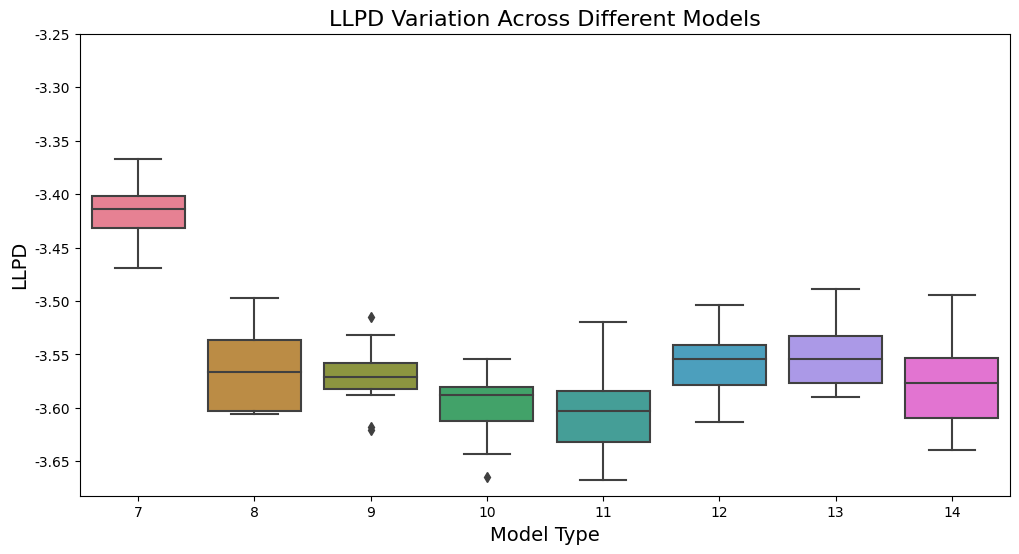

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define new column names
column_names = ["Index", "Lambda", "SP_Mean", "SP_Variance", "LLPD_Score", "UserID", "ModelType"]

# Convert your merged dictionary to DataFrame
df_llpd_plot = pd.DataFrame.from_dict(out_all_models, orient="index", columns=column_names)

# Ensure ModelType is treated as categorical
df_llpd_plot["ModelType"] = df_llpd_plot["ModelType"].astype(int).astype("category")

# Group to calculate mean and std per model type
llpd_mean_by_type = df_llpd_plot.groupby("ModelType")["LLPD_Score"].mean().reset_index()
llpd_std_by_type = df_llpd_plot.groupby("ModelType")["LLPD_Score"].std().reset_index()

# Add standard deviation column to the mean DataFrame
llpd_mean_by_type["std"] = llpd_std_by_type["LLPD_Score"]

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="ModelType", y="LLPD_Score", data=df_llpd_plot, palette="husl")

plt.xlabel("Model Type", fontsize=14)
plt.ylabel("LLPD", fontsize=14)
plt.title("LLPD Variation Across Different Models", fontsize=16)
plt.ylim(top=-3.25)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.xticks(rotation=0)

# Save
plot_output_path = os.path.join(figfol, "llpd_error_plot_combined_models_6.png")
plt.savefig(plot_output_path, dpi=400)
plt.show()


In [11]:
from collections import defaultdict
import numpy as np
import pickle
import os

# Count test points per mtype
mtype_test_counts = defaultdict(list)

all_model_files = fname_o

for file_path in all_model_files:
    try:
        with open(file_path, "rb") as file:
            [holdout_mask, Yte_sample, llpd_val, n_test, l, m_seed, sp_mean,
             sp_var, h_prop, uid, nsample_o, Yte_fit,
             cv_test, Y, muest, Yte_cv, Yte_lpmf, kl_comp] = pickle.load(file)

        filename = os.path.basename(file_path)
        filename_parts = filename.split('_')
        mtype = int(filename_parts[1]) if len(filename_parts) >= 4 else -1

        se_index = holdout_mask == 1.
        num_test_points = np.sum(se_index)

        mtype_test_counts[mtype].append(num_test_points)

    except Exception as e:
        print(f"❌ Error in {file_path}: {e}")

# Print test point stats per mtype
print("\n📊 Number of test points per mtype:")
for mtype in sorted(mtype_test_counts):
    counts = mtype_test_counts[mtype]
    print(f"mtype {mtype}: test data points = {np.mean(counts):.1f}, n_models = {len(counts)}")



📊 Number of test points per mtype:
mtype 8: test data points = 19368.0, n_models = 20
mtype 9: test data points = 19368.0, n_models = 17
mtype 10: test data points = 19368.0, n_models = 20
mtype 11: test data points = 19368.0, n_models = 20
mtype 12: test data points = 19368.0, n_models = 20
mtype 13: test data points = 19368.0, n_models = 20
mtype 14: test data points = 19368.0, n_models = 11


In [12]:
from collections import defaultdict
import numpy as np
import pickle
import os

TARGET_N = 19368.0  # normalize all models to this size

# Store adjusted mean LLPDs
normalized_llpd = defaultdict(list)

all_model_files = fname_o

for file_path in all_model_files:
    try:
        with open(file_path, "rb") as file:
            [holdout_mask, Yte_sample, llpd_val, n_test, l, m_seed, sp_mean,
             sp_var, h_prop, uid, nsample_o, Yte_fit,
             cv_test, Y, muest, Yte_cv, Yte_lpmf, kl_comp] = pickle.load(file)

        se_index = holdout_mask == 1.
        ll_vals = cv_test[se_index]
        
        # Extract mtype from filename
        filename = os.path.basename(file_path)
        mtype = int(filename.split('_')[1]) if '_' in filename else -1

        # Normalize to 19154 if needed
        if len(ll_vals) > TARGET_N:
            ll_vals = np.random.choice(ll_vals, size=TARGET_N, replace=False)

        elif len(ll_vals) < TARGET_N:
            # Either skip or pad (optional)
            continue

        # Compute adjusted mean LLPD
        llpd_fixed = np.mean(ll_vals)
        normalized_llpd[mtype].append(llpd_fixed)

    except Exception as e:
        print(f"❌ Error in {file_path}: {e}")

# ✅ Show results
print("\n📊 Normalized mean LLPD (fixed to 19154 points):")
for mtype in sorted(normalized_llpd):
    values = normalized_llpd[mtype]
    print(f"mtype {mtype}: mean = {np.mean(values):.4f}, std = {np.std(values):.4f}, n_models = {len(values)}")



📊 Normalized mean LLPD (fixed to 19154 points):
mtype 8: mean = -inf, std = nan, n_models = 20
mtype 9: mean = -inf, std = nan, n_models = 17
mtype 10: mean = -inf, std = nan, n_models = 20
mtype 11: mean = -inf, std = nan, n_models = 20
mtype 12: mean = -3.5603, std = 0.0276, n_models = 20
mtype 13: mean = -inf, std = nan, n_models = 20
mtype 14: mean = -inf, std = nan, n_models = 11


/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


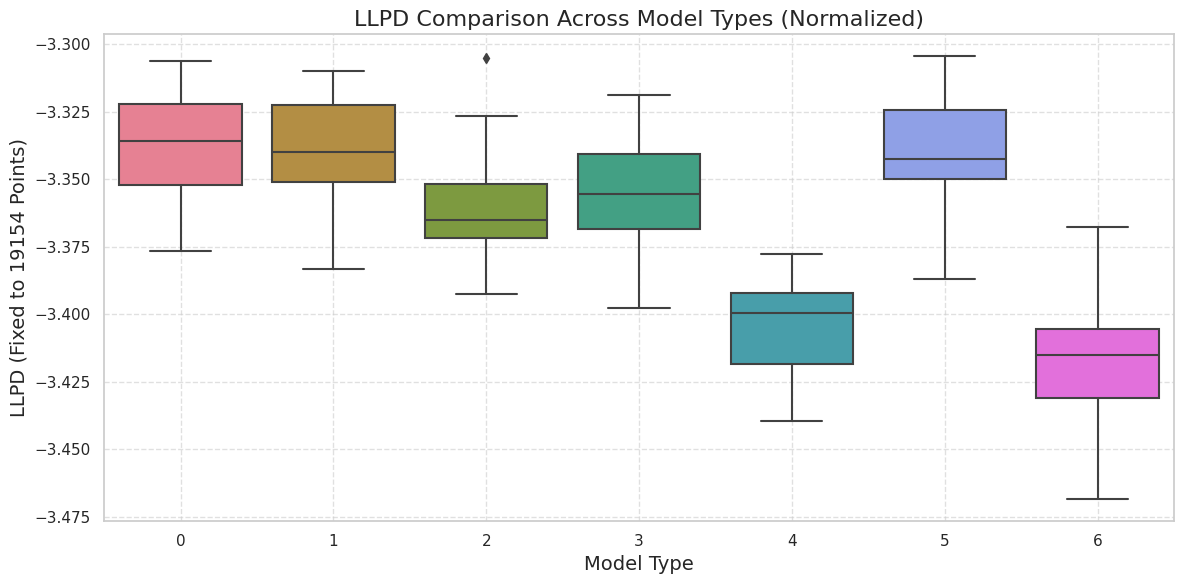

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step 1: Convert normalized_llpd to a DataFrame
rows = []
for mtype, values in normalized_llpd.items():
    for v in values:
        rows.append({"ModelType": mtype, "LLPD": v})

df_llpd_plot = pd.DataFrame(rows)
df_llpd_plot["ModelType"] = df_llpd_plot["ModelType"].astype("category")

# Step 2: Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_llpd_plot, x="ModelType", y="LLPD", palette="husl")

plt.xlabel("Model Type", fontsize=14)
plt.ylabel("LLPD (Fixed to 19154 Points)", fontsize=14)
plt.title("LLPD Comparison Across Model Types (Normalized)", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Optional: save
plot_path = os.path.join(figfol, "llpd_boxplot_normalized_19154.png")
plt.savefig(plot_path, dpi=300)
plt.show()


In [67]:
from collections import defaultdict
import numpy as np
import pickle
import os

# Recompute per-mtype LLPDs using real number of test points
mtype_llpds_true = defaultdict(list)

all_model_files = fname_o + fname_o_6

for file_path in all_model_files:
    try:
        with open(file_path, "rb") as file:
            [holdout_mask, Yte_sample, llpd_val, n_test, l, m_seed, sp_mean,
             sp_var, h_prop, uid, nsample_o, Yte_fit,
             cv_test, Y, muest, Yte_cv, Yte_lpmf, kl_comp] = pickle.load(file)

        # Get test indices based on holdout mask
        se_index = (holdout_mask == 1.)
        test_indices = np.where(se_index)[0]

        # Mean LLPD over real number of test points
        if len(test_indices) > 0:
            temp_ll = np.mean(cv_test[test_indices])
        else:
            temp_ll = np.nan

        # Extract mtype from filename
        filename = os.path.basename(file_path)
        filename_parts = filename.split('_')
        mtype = int(filename_parts[1]) if len(filename_parts) >= 4 else -1

        # Store
        mtype_llpds_true[mtype].append(temp_ll)

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")


In [68]:
print("\n📊 Mean LLPD per mtype (using true number of test points):")
for mtype in sorted(mtype_llpds_true):
    values = mtype_llpds_true[mtype]
    print(f"mtype {mtype}: mean = {np.mean(values):.6f}, std = {np.std(values):.6f}, "f"min = {np.min(values):.6f}, max = {np.max(values):.6f}, n_models = {len(values)}")



📊 Mean LLPD per mtype (using true number of test points):
mtype 0: mean = -0.335822, std = 0.002144, min = -0.340482, max = -0.332611, n_models = 20
mtype 1: mean = -0.336369, std = 0.002025, min = -0.341097, max = -0.333182, n_models = 20
mtype 2: mean = -0.337966, std = 0.002263, min = -0.341335, max = -0.332283, n_models = 20
mtype 3: mean = -0.337796, std = 0.002095, min = -0.341881, max = -0.333728, n_models = 20
mtype 4: mean = -0.342471, std = 0.001768, min = -0.346134, max = -0.339801, n_models = 20
mtype 5: mean = -0.336052, std = 0.002102, min = -0.341598, max = -0.332477, n_models = 20
mtype 6: mean = -0.344473, std = 0.002510, min = -0.350620, max = -0.339207, n_models = 20


In [69]:
out = pkl.load(open('comparison_model', "rb"))
print(type(out))  # Check if it's a dictionary or list
print(len(out))   # Check number of elements
print(out[0])     # Print one entry to inspect its structure


<class 'dict'>
120
[0, 100, 0.06059627021136009, 0.0408163265306122, -3.3357373475427203, 30, 0]


In [70]:
out = pd.DataFrame.from_dict(out, orient='index')
print(out.shape)  # Check if the shape matches (rows, columns)


(120, 7)


In [71]:
# Load the data
out = pkl.load(open('comparison_model', "rb"))

# Convert the dictionary to a DataFrame more carefully
# Method 1: Try converting dict values to DataFrame directly
out_df = pd.DataFrame.from_dict(out, orient='index', columns=['Index','rank','lambda','upsilon','llpd','uid','Model'])

# If Method 1 doesn't work, try Method 2:
# First convert dict to list of lists
data_list = [value for value in out.values()]
out_df = pd.DataFrame(data_list, columns=['Index','rank','lambda','upsilon','llpd','uid','Model'])

# Display the first 20 rows
print(out_df.head(20))

    Index  rank    lambda   upsilon      llpd  uid  Model
0       0   100  0.060596  0.040816 -3.335737   30      0
1       1   100  0.060596  0.040816 -3.394061   30      4
2       2   100  0.060596  0.040816 -3.351756   30      0
3       3   100  0.060596  0.040816 -3.371079   30      1
4       4   100  0.060596  0.040816 -3.317078   30      0
5       5   100  0.060596  0.040816 -3.365383   30      2
6       6   100  0.060596  0.040816 -3.336005   30      0
7       7   100  0.060596  0.040816 -3.392644   30      2
8       8   100  0.060596  0.040816 -3.346224   30      5
9       9   100  0.060596  0.040816 -3.319387   30      5
10     10   100  0.060596  0.040816 -3.376695   30      0
11     11   100  0.060596  0.040816 -3.421014   30      4
12     12   100  0.060596  0.040816 -3.345962   30      5
13     13   100  0.060596  0.040816 -3.378402   30      4
14     14   100  0.060596  0.040816 -3.350975   30      1
15     15   100  0.060596  0.040816 -3.364605   30      2
16     16   10

<font color=blue>**Our analysis suggest that the model 0, i.e., MEM is best with highest out of sample LLPD$_o$.** </font>

In [72]:
# First, convert the dictionary to a DataFrame
out_df = pd.DataFrame.from_dict(out, orient='index')

# Now rename the columns
out_df.columns = ['Index', 'rank', 'lambda', 'upsilon', 'llpd', 'uid', 'Model']

# Now we can perform the groupby operation
results = out_df.groupby(['Model'], as_index=False).agg({'llpd': ['mean', 'std']})

print(results)

  Model      llpd          
             mean       std
0     0 -3.336061  0.019514
1     1 -3.341048  0.020001
2     2 -3.358865  0.022243
3     3 -3.356661  0.021063
4     4 -3.403350  0.017467
5     5 -3.339607  0.018942


In [73]:
# Convert dictionary to DataFrame
out_df = pd.DataFrame.from_dict(out, orient='index')

# Rename columns
out_df.columns = ['Index', 'rank', 'lambda', 'upsilon', 'llpd', 'uid', 'Model']

# Now perform the groupby and transform to get the LaTeX output
out_sub = out_df.groupby(['Model'], as_index=False).mean()[['Model','llpd']].transpose()

# Print LaTeX formatted table
print(out_sub.to_latex(float_format="%.4f", bold_rows=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &       0 &       1 &       2 &       3 &       4 &       5 \\
\midrule
\textbf{Model} &  0.0000 &  1.0000 &  2.0000 &  3.0000 &  4.0000 &  5.0000 \\
\textbf{llpd } & -3.3361 & -3.3410 & -3.3589 & -3.3567 & -3.4033 & -3.3396 \\
\bottomrule
\end{tabular}



In [74]:
l,m_seed,sp_mean, sp_var

(100, 6, 0.060596, 0.040816)

In [75]:
# Convert dictionary to DataFrame
out_df = pd.DataFrame.from_dict(out, orient='index')
out_df.columns = ['Index', 'rank', 'lambda', 'upsilon', 'llpd', 'uid', 'Model']

# Sort by LLPD in descending order (highest first) and get the first row
best_model = out_df.sort_values('llpd', ascending=False).iloc[0]

print("Best Model Configuration:")
print(f"Model Type (mtype): {int(best_model['Model'])}")
print(f"Model Seed (mseed): {int(best_model['Index'])}")
print(f"LLPD Score: {best_model['llpd']:.6f}")
print(f"Other parameters:")
print(f"  Lambda: {best_model['lambda']}")
print(f"  Upsilon: {best_model['upsilon']}")
print(f"  Rank: {int(best_model['rank'])}")

Best Model Configuration:
Model Type (mtype): 5
Model Seed (mseed): 86
LLPD Score: -3.304545
Other parameters:
  Lambda: 0.06059627021136009
  Upsilon: 0.0408163265306122
  Rank: 100


In [76]:
# Given values
index = int(best_model['Index']) # your best model's index
mtype = int(best_model['Model'])  # your best model's type
uid = 30    # from the data

# Calculate actual mseed (0-19)
mseed = index % 20  # This gives us which run number it was within its mtype group

print(f"For index {index}:")
print(f"Model Type (mtype): {mtype}")
print(f"Model Seed (mseed): {mseed}")
print(f"UID: {uid}")
print(f"\nExpected filename: {uid}_{mtype}_{mseed}_model_nb_cvtest.pkl")

For index 86:
Model Type (mtype): 5
Model Seed (mseed): 6
UID: 30

Expected filename: 30_5_6_model_nb_cvtest.pkl


In [77]:
# Load and inspect comparison_model file
import pickle as pkl

# Load the data
with open('comparison_model', 'rb') as f:
    data = pkl.load(f)

# Print general information
print("Type of data:", type(data))
print("Number of entries:", len(data))
print("\nStructure of each entry:")
for i in range(3):  # Show first 3 entries
    print(f"\nEntry {i}:")
    print(f"Raw data: {data[i]}")
    print("Interpreted as:")
    print(f"  Index: {data[i][0]}")
    print(f"  Rank: {data[i][1]}")
    print(f"  Lambda: {data[i][2]}")
    print(f"  Upsilon: {data[i][3]}")
    print(f"  LLPD: {data[i][4]}")
    print(f"  UID: {data[i][5]}")
    print(f"  Model Type: {data[i][6]}")

print("\nUnique Model Types:", sorted(set(data[i][6] for i in range(len(data)))))
print("Unique UIDs:", sorted(set(data[i][5] for i in range(len(data)))))

Type of data: <class 'dict'>
Number of entries: 120

Structure of each entry:

Entry 0:
Raw data: [0, 100, 0.06059627021136009, 0.0408163265306122, -3.3357373475427203, 30, 0]
Interpreted as:
  Index: 0
  Rank: 100
  Lambda: 0.06059627021136009
  Upsilon: 0.0408163265306122
  LLPD: -3.3357373475427203
  UID: 30
  Model Type: 0

Entry 1:
Raw data: [1, 100, 0.06059627021136009, 0.0408163265306122, -3.3940612259344527, 30, 4]
Interpreted as:
  Index: 1
  Rank: 100
  Lambda: 0.06059627021136009
  Upsilon: 0.0408163265306122
  LLPD: -3.3940612259344527
  UID: 30
  Model Type: 4

Entry 2:
Raw data: [2, 100, 0.06059627021136009, 0.0408163265306122, -3.351755606155532, 30, 0]
Interpreted as:
  Index: 2
  Rank: 100
  Lambda: 0.06059627021136009
  Upsilon: 0.0408163265306122
  LLPD: -3.351755606155532
  UID: 30
  Model Type: 0

Unique Model Types: [0, 1, 2, 3, 4, 5]
Unique UIDs: [30]
